# Test validity partial step 4 : $P(B_f | ...) \propto \eta^t \ \left(\bold{C}_{\rm approx}^{1/2}(\bold{N_{c}}^{-1} + \bold{C}_{\rm approx}^{-1}) \bold{C}_{\rm approx}^{1/2} \right)^{-1} \ \eta$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro
import numpyro.distributions as dist

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


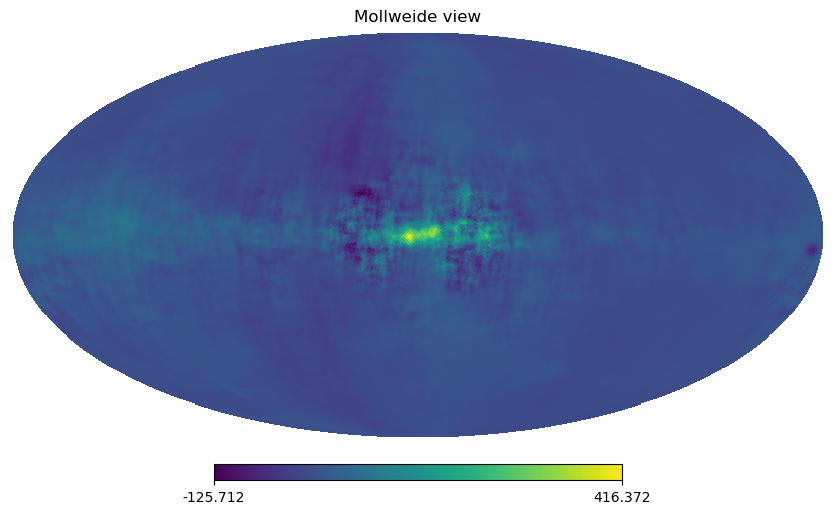

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, n_pix

In [5]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v4/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v2d.toml'


In [6]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [7]:
reduction_noise = 1
# MICMAC_sampler_obj.r_true = 1

In [8]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [9]:
instrument = get_instrument(instr_name)

noise_bool = True
# noise_bool = False

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise_bool)[:, 1:, :]   # keep only Q and U


In [10]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [11]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.n_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.n_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [12]:
# input_freq_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)

# true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.n_frequencies).reshape((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix),order='F')

# input_freq_maps = input_cmb_maps + freq_maps_fgs

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [13]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]

In [14]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

red_cov_approx_matrix = np.copy(theoretical_red_cov_r0_total)
c_ell_approx = micmac.get_c_ells_from_red_covariance_matrix(red_cov_approx_matrix)

In [15]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+1)
map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
# eta_maps = MAC_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !


In [16]:
n_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = n_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

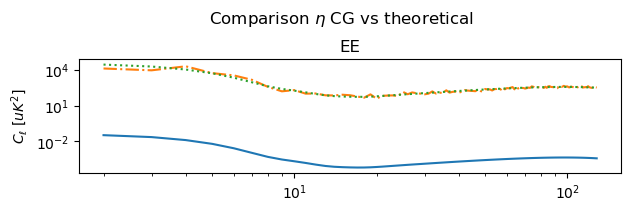

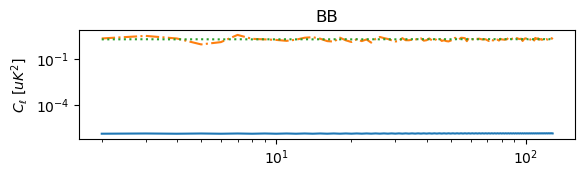

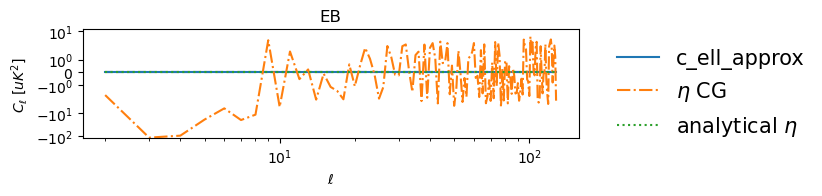

In [17]:
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

covariance_noise = np.zeros_like(c_ell_approx)

cl_noise = BtinvNB[0,0]*hp.nside2resol(MICMAC_sampler_obj.nside)**2
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))

# analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_personalized/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)

# analytical_eta_term = np.zeros_like(c_ell_approx)
analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]


eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical")

list_correl = ['EE', 'BB', 'EB']
ell_arange = np.arange(MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin) + MICMAC_sampler_obj.lmin
for j in range(n_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])
    
    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    
    plt.plot(ell_arange, c_ell_approx[j,:], label='c_ell_approx')
    plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    
    plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

    if MICMAC_sampler_obj.nstokes == 3 and j < n_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    
    plt.ylabel("$C_\ell$ [$uK^2$]")
    if j == n_correl_to_plot-1:
        plt.xlabel(r"$\ell$")


    plt.show()

In [18]:
PRNGKey = random.PRNGKey(0)
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))

map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

s_c_sample = wiener_filter_term + fluctuation_maps

CG-Python-0 WF finished in  None iterations !!
Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!


In [19]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter

In [20]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


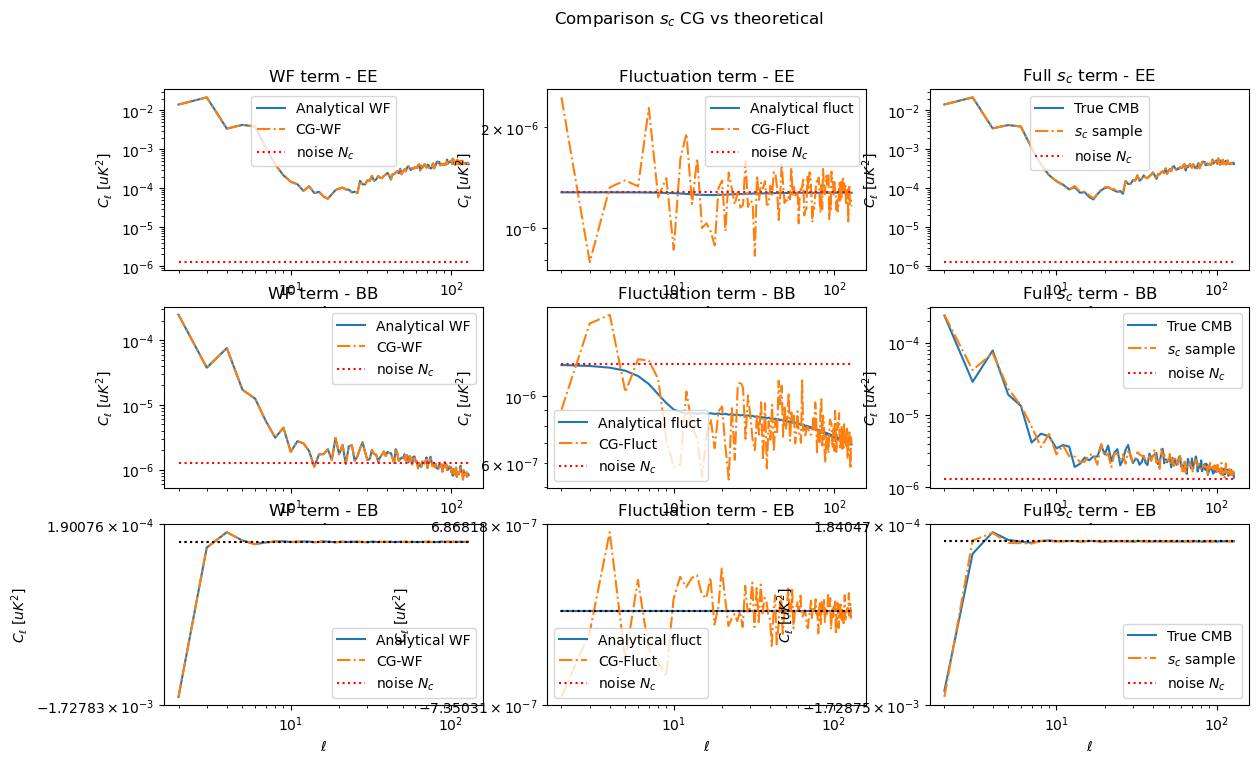

In [21]:
list_correl = ['EE', 'BB', 'EB']

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)


analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(n_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [22]:
_fake_mixing_matrix = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.n_components, init_params, pos_special_freqs=[0,-1])


def get_conditional_proba_spectral_likelihood_JAX_un_pix(complete_mixing_matrix, full_data_without_CMB, suppress_low_modes=True):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    BtinvNB_fg = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    BtinvN_fg = get_BtinvN(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)/jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', BtinvN_fg, full_data_without_CMB)
    if suppress_low_modes:
        covariance_unity = jnp.zeros((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes))
        # covariance_unity = covariance_unity.at[lmin:,...].set(jnp.eye(nstokes))
        covariance_unity = covariance_unity.at[:,...].set(jnp.eye(MICMAC_sampler_obj.nstokes))
        for i in range(MICMAC_sampler_obj.n_components-1):
            full_data_without_CMB_with_noise = full_data_without_CMB_with_noise.at[i].set(maps_x_red_covariance_cell_JAX(jnp.copy(full_data_without_CMB_with_noise[i]), covariance_unity, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter))

    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, BtinvNB_fg, full_data_without_CMB_with_noise)
    return -(-first_term_complete + 0)/2.

def get_test_biased_conditional_proba_mixing_matrix_JAX(new_params_mixing_matrix, full_data_without_CMB):
        params_mixing_matrix = jnp.copy(new_params_mixing_matrix)

        # new_mixing_matrix = create_mixing_matrix_jax(params_mixing_matrix, self.n_components, self.n_frequencies, pos_special_freqs=self.pos_special_freqs)
        _fake_mixing_matrix.update_params(params_mixing_matrix.reshape((MICMAC_sampler_obj.n_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.n_components-1),order='F'),jax_use=True)
        new_mixing_matrix = _fake_mixing_matrix.get_B(jax_use=True)
        
        # log_proba_spectral_likelihood = self.get_conditional_proba_spectral_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB))
        log_proba_spectral_likelihood = get_conditional_proba_spectral_likelihood_JAX_un_pix(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB))

        # log_proba_perturbation_likelihood = self.get_conditional_proba_perturbation_likelihood_JAX_v2_slow_un_pix(jnp.copy(new_mixing_matrix), modified_sample_eta_maps, red_cov_approx_matrix, with_prints=False)
        return log_proba_spectral_likelihood #+ log_proba_perturbation_likelihood



In [23]:

def separate_single_MH_step(random_PRNGKey, old_sample, step_size, log_proba, **model_kwargs):
    
    def map_func(carry, index_Bf):
        rng_key, key_proposal, key_accept = random.split(carry[0], 3)

        u_proposal = dist.Normal(carry[1][index_Bf], step_size[index_Bf]).sample(key_proposal)
        
        # _fake_mixing_matrix.update_params(carry[1].reshape((MICMAC_sampler_obj.n_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.n_components-1),order='F'))
        # old_mixing_matrix = self._fake_mixing_matrix.get_B(jax_use=True)
        
        proposal_params = jnp.copy(carry[1])
        proposal_params = proposal_params.at[index_Bf].set(u_proposal)
        # self._fake_mixing_matrix.update_params(proposal_params.reshape((self.n_frequencies-jnp.size(self.pos_special_freqs), self.n_components-1),order='F'))
        # proposal_mixing_matrix = self._fake_mixing_matrix.get_B(jax_use=True)

        # accept_prob = -(log_proba(old_mixing_matrix, **model_kwargs) - log_proba(proposal_mixing_matrix, **model_kwargs))
        accept_prob = -(log_proba(carry[1], **model_kwargs) - log_proba(proposal_params, **model_kwargs))
        new_param = jnp.where(jnp.log(dist.Uniform().sample(key_accept)) < accept_prob, u_proposal, carry[1][index_Bf])
        
        proposal_params = proposal_params.at[index_Bf].set(new_param)
        return (rng_key, proposal_params), new_param

    carry, new_sample = jlax.scan(map_func, (random_PRNGKey, jnp.ravel(old_sample,order='F')), jnp.arange(jnp.ravel(old_sample,order='F').shape[0]))
    latest_PRNGKey = carry[0]
    return latest_PRNGKey, new_sample.reshape(old_sample.shape,order='F')


In [24]:
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/fisher_so-sat_d0s0_lmin2_lmax128_nomask_Alens1.0_r0.0_B_noiselens.txt'
path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'

Fisher_matrix = np.loadtxt(path_Fisher)
minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)

len_pos_special_freqs = len(MICMAC_sampler_obj.pos_special_freqs)
step_size_B_f_ravel = np.zeros(((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*2))
# step_size_B_f[MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs] = minimum_std_Fisher_diag[:MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs]
# step_size_B_f[MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs:] = minimum_std_Fisher_diag[MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs:2*(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)]
# step_size_B_f_ravel[:MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs] = minimum_std_Fisher_diag[1:MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs+1]
# step_size_B_f_ravel[MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs:] = minimum_std_Fisher_diag[-(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)-1:-1]
step_size_B_f_ravel[:MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs] = minimum_std_Fisher_diag[:MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs]
step_size_B_f_ravel[MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs:] = minimum_std_Fisher_diag[-(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)-1:-1]


step_size_B_f = step_size_B_f_ravel.reshape((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,2),order='F')

In [25]:
minimum_std_Fisher_diag, step_size_B_f

(array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
        4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
        5.55036342e-04]),
 array([[1.22719235e-04, 4.28340683e-05],
        [4.72984090e-05, 1.62270766e-05],
        [4.44084763e-05, 1.52905384e-05],
        [5.23546882e-05, 1.82529746e-05]]))

In [26]:
# step_size_B_f = 10**(-6)*np.ones_like(step_size_B_f)
# step_size_B_f = 10**(-5)*np.ones_like(step_size_B_f)
# step_size_B_f = 10**(-4)*np.ones_like(step_size_B_f)
# step_size_B_f = 10**(-3)*np.ones_like(step_size_B_f)
# step_size_B_f = 10**(-2)*np.ones_like(step_size_B_f)

# step_size_B_f = 10**(-7)*np.ones_like(step_size_B_f)

In [27]:
init_params

array([[0.33858815, 0.00979233],
       [0.02963068, 0.05147511],
       [0.00998213, 0.12913911],
       [0.00328725, 0.44076761]])

In [28]:
frequency_array = MICMAC_sampler_obj.frequency_array

In [29]:
# alternative_synch_step_size = (frequency_array[0]/frequency_array)**3
# alternative_dust_step_size = 1/(frequency_array[-1]/frequency_array)**3

# col_dim_B_f = MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs

# step_size_B_f[:,0] = alternative_synch_step_size[1:col_dim_B_f+1]/100
# step_size_B_f[:,1] = alternative_dust_step_size[1:col_dim_B_f+1]/100

# init_params, step_size_B_f*100

In [46]:
# number_steps_sampler = 30000
# number_steps_sampler = 20000
# number_steps_sampler = 15000
number_steps_sampler = 10000
# number_steps_sampler = 8000
# number_steps_sampler = 7000
# number_steps_sampler = 5000
# number_steps_sampler = 3000
# number_steps_sampler = 2000
number_steps_sampler = 1000
# # number_steps_sampler = 500
# number_steps_sampler = 400
initial_step_size_B_f = np.copy(step_size_B_f)
# gap = 0
# init_params_mixing_matrix = init_params.ravel(order='F') + gap*np.random.uniform(low=-step_size_B_f,high=step_size_B_f, size=((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*2))
init_params_mixing_matrix = init_params #+ gap*np.random.uniform(low=-step_size_B_f,high=step_size_B_f, size=((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs),2))

dimension = np.size(init_params.ravel(order='F'))

num_sample_AM = np.inf
# num_sample_AM = 10000
# num_sample_AM = 1000
# num_sample_AM = 500
# num_sample_AM = 250
# num_sample_AM = 100
# num_sample_AM = 50
# epsilon_cov = 10**(-20)
# epsilon_cov = 10**(-18)
epsilon_cov = 10**(-20)
# scale_param = 2.4**2/dimension
scale_param = 2.38**2/dimension

In [47]:
red_true_CMB = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [48]:
# print("Using slow version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v2_slow_JAX)
# print("Using ALT slow version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v2_slow_JAX_alt)
# print("Using ALT_2 slow version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v2_slow_JAX_alt_2)
# print("Using ALT_harm slow version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v2_slow_JAX_alt_harm)
# print("Using ALT_harm_2 slow version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v2_slow_JAX_alt_harm_2)
# print("Using v1 ALT_harm slow version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v1_slow_JAX_alt_harm)

# print("Using v1 ALT_harm slow version + ALT classic spectral likelihood of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v1_slow_JAX_alt_harm)
# log_proba_func = jax.jit(MICMAC_sampler_obj.test_get_conditional_proba_mixing_matrix_v1_slow_JAX_alt_harm)

# print("Using marginalised version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(get_alternative_sampling_B_f)

print("Using biased version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(get_conditional_proba_spectral_likelihood_JAX_un_pix)
log_proba_func = jax.jit(get_test_biased_conditional_proba_mixing_matrix_JAX)


# print("Using v1c ALT_harm slow version + ALT classic spectral likelihood of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v1c_slow_JAX_alt_harm)
# print("Using v1 ALT_harm slow version + classic spectral likelihood of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v1b_slow_JAX_alt_harm)
# print("Using v1 Radek_harm slow version + classic spectral likelihood of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_conditional_proba_mixing_matrix_v1b_slow_JAX_alt_harm_Radek)
# print("Getting biased version of B_f sampling !", flush=True)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_biased_conditional_proba_mixing_matrix_v2_slow_JAX)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_biased_conditional_proba_mixing_matrix_v2_slow_JAX_alt)
# log_proba_func = jax.jit(MICMAC_sampler_obj.get_biased_conditional_proba_mixing_matrix_v1_slow_JAX_alt)

Using biased version of B_f sampling !


In [49]:
PRNGKey = random.PRNGKey(42)

In [50]:
%%time

all_B_f_sample = jnp.zeros((number_steps_sampler+1,MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs,2))

all_B_f_sample = all_B_f_sample.at[0].set(init_params_mixing_matrix*np.random.uniform(low=.9,high=1.1, size=((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs),2)))
# all_B_f_sample = all_B_f_sample.at[0].set(init_params_mixing_matrix*np.random.uniform(low=.5,high=1.5, size=((MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs),2)))


full_data_without_CMB = input_freq_maps - jnp.einsum('f,sp->fsp', mixing_matrix_sampled[:,0], input_cmb_maps[0])
covariance_unity = jnp.zeros((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes))

covariance_unity = covariance_unity.at[:,...].set(jnp.eye(MICMAC_sampler_obj.nstokes))

for i in range(MICMAC_sampler_obj.n_components-1):
    full_data_without_CMB = full_data_without_CMB.at[i].set(maps_x_red_covariance_cell_JAX(jnp.copy(full_data_without_CMB[i]), covariance_unity, nside=nside, lmin=lmin, n_iter=n_iter))

dimension_param_B_f = np.size(all_B_f_sample[0].ravel(order='F'))

for i in range(0,number_steps_sampler+1):
    old_PRNGKey, PRNGKey = random.split(PRNGKey)
    # step_size_B_f = initial_step_size_B_f
    if i < num_sample_AM:
        # covariance_matrix_B_f = jnp.diag(initial_step_size_B_f.ravel(order='F'))
        covariance_matrix_B_f = jnp.diag(initial_step_size_B_f.ravel(order='F')**2)
    elif i == num_sample_AM:
        # step_size_B_f = jnp.sqrt(scale_param*(jnp.var(all_B_f_sample[:i],axis=0) + epsilon_cov))
        
        # mean_sample_t_m1 = jnp.mean(all_B_f_sample[:i-1],axis=0).ravel(order='F')
        mean_sample_t = jnp.mean(all_B_f_sample[:i],axis=0).ravel(order='F')
        
        empirical_covariance = micmac.get_empirical_covariance_JAX(all_B_f_sample[:i].reshape((i,(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs)*2),order='F'))
        covariance_matrix_B_f = scale_param*(empirical_covariance + epsilon_cov*jnp.eye(dimension_param_B_f))
    else:
        mean_sample_t_m1 = np.copy(mean_sample_t)
        mean_sample_t = (i/(i+1))*mean_sample_t_m1 + all_B_f_sample[i].ravel(order='F')/(i+1)
        covariance_matrix_B_f = ((i-1)/i)*covariance_matrix_B_f + (scale_param/i)*(jnp.einsum('i,j->ij', all_B_f_sample[i].ravel(order='F'), all_B_f_sample[i].ravel(order='F'))
                                + i*jnp.einsum('i,j->ij',mean_sample_t_m1,mean_sample_t_m1)
                                - (i+1)*jnp.einsum('i,j->ij',mean_sample_t,mean_sample_t)
                                + epsilon_cov*jnp.eye(dimension_param_B_f))
    # step_size_B_f = jnp.diag(jsp.sqrtm(covariance_matrix_B_f))
    step_size_B_f = jnp.diag(jnp.array(jsp.linalg.sqrtm(covariance_matrix_B_f),dtype=jnp.float64))
    

    PRNGKey, new_param = separate_single_MH_step(random_PRNGKey=PRNGKey, old_sample=all_B_f_sample[i], step_size=step_size_B_f, log_proba=log_proba_func, 
                                        full_data_without_CMB=full_data_without_CMB)
    if i%10 == 0:
        print(i, jnp.diag(covariance_matrix_B_f), flush=True)
        print(i, np.abs(new_param-all_B_f_sample[i])/init_params, flush=True)
    all_B_f_sample = all_B_f_sample.at[i+1].set(new_param)


0 [1.50600107e-08 2.23713949e-09 1.97211277e-09 2.74101337e-09
 1.83475741e-09 2.63318016e-10 2.33800564e-10 3.33171080e-10]
0 [[1.38336966e-04 2.35570553e-03]
 [2.00470281e-03 0.00000000e+00]
 [4.61815212e-03 3.31625623e-05]
 [3.67618467e-03 2.61527194e-05]]
10 [1.50600107e-08 2.23713949e-09 1.97211277e-09 2.74101337e-09
 1.83475741e-09 2.63318016e-10 2.33800564e-10 3.33171080e-10]
10 [[5.11559875e-04 0.00000000e+00]
 [0.00000000e+00 1.84696369e-04]
 [1.57392686e-03 1.15007602e-05]
 [0.00000000e+00 0.00000000e+00]]
20 [1.50600107e-08 2.23713949e-09 1.97211277e-09 2.74101337e-09
 1.83475741e-09 2.63318016e-10 2.33800564e-10 3.33171080e-10]
20 [[0.00016843 0.00048828]
 [0.00075995 0.0002138 ]
 [0.         0.        ]
 [0.         0.        ]]
30 [1.50600107e-08 2.23713949e-09 1.97211277e-09 2.74101337e-09
 1.83475741e-09 2.63318016e-10 2.33800564e-10 3.33171080e-10]
30 [[0.00017614 0.00114878]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
40 [1.50600107e-08

In [51]:
all_B_f_sample.var(axis=0)

Array([[8.37312867e-06, 3.91709805e-06],
       [4.29331557e-06, 3.03360016e-06],
       [5.87310530e-06, 1.51869272e-06],
       [4.18479977e-05, 4.85340659e-06]], dtype=float64)

In [52]:
all_B_f_sample_synch = all_B_f_sample[:,:,0]
all_B_f_sample_dust = all_B_f_sample[:,:,1]

frequency_array = np.array(instrument['frequency'])


plt.figure(figsize=(21,8))
plt.suptitle('Mixing matrix parameters sampled vs iterations')
plt.subplot(221)
plt.title(('Synch parameters'))
for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    plt.plot([0,number_steps_sampler+1], [init_params[i,0],init_params[i,0]])
    plt.plot(np.arange(number_steps_sampler+1), all_B_f_sample_synch[:,i], '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
plt.legend()
plt.yscale('log')
# plt.xlabel('Iterations')
plt.ylabel('B_f params')

plt.subplot(222)
plt.title(('Dust parameters'))
for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    plt.plot([0,number_steps_sampler+1], [init_params[i,1],init_params[i,1]])
    plt.plot(np.arange(number_steps_sampler+1), all_B_f_sample_dust[:,i], '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
plt.legend()
plt.yscale('log')
# plt.xlabel('Iterations')
plt.ylabel('B_f params')


# plt.figure(figsize=(14,4))
plt.suptitle('Relative error sampling vs iterations')
plt.subplot(223)
# plt.title(('Synch parameters'))
for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    relative_error = np.abs((all_B_f_sample_synch[:,i]-init_params[i,0])/init_params[i,0])
#     plt.plot([0,number_steps_sampler+1], [init_params[i,0],init_params[i,0]])
    plt.plot(np.arange(number_steps_sampler+1), relative_error, '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')

if num_sample_AM != np.inf:
    plt.plot([num_sample_AM,num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
plt.legend()
# plt.loglog()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative error of B_f synch params')

plt.subplot(224)
# plt.title(('Dust parameters'))
for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
    relative_error = np.abs((all_B_f_sample_dust[:,i]-init_params[i,1])/init_params[i,1])
#     plt.plot([0,number_steps_sampler+1], [init_params[i,1],init_params[i,1]])
    plt.plot(np.arange(number_steps_sampler+1), relative_error, '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
if num_sample_AM != np.inf:
    plt.plot([num_sample_AM,num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
plt.legend()
# plt.loglog()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative error of B_f dust params')

plt.show()


In [53]:
init_params[:,0], all_B_f_sample[-1]

(array([0.33858815, 0.02963068, 0.00998213, 0.00328725]),
 Array([[ 0.34072378,  0.00722105],
        [ 0.02853551,  0.05325572],
        [ 0.00639058,  0.13445322],
        [-0.01874419,  0.4729611 ]], dtype=float64))

In [54]:
# all_B_f_sample_synch = all_B_f_sample[:,:,0]
# all_B_f_sample_dust = all_B_f_sample[:,:,1]

# plt.figure(figsize=(14,4))
# plt.suptitle('Relative error sampling vs iterations')
# plt.subplot(121)
# plt.title(('Synch parameters'))
# for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
#     relative_error = np.abs((all_B_f_sample_synch[:,i]-init_params[i,0])/init_params[i,0])
# #     plt.plot([0,number_steps_sampler+1], [init_params[i,0],init_params[i,0]])
#     plt.plot(np.arange(number_steps_sampler+1), relative_error, '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')

# plt.plot([num_sample_AM,num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
# plt.legend()
# plt.loglog()
# plt.xlabel('Iterations')
# plt.ylabel('Relative error of B_f synch params')

# plt.subplot(122)
# plt.title(('Dust parameters'))
# for i in range(MICMAC_sampler_obj.n_frequencies-len_pos_special_freqs):
#     relative_error = np.abs((all_B_f_sample_dust[:,i]-init_params[i,1])/init_params[i,1])
# #     plt.plot([0,number_steps_sampler+1], [init_params[i,1],init_params[i,1]])
#     plt.plot(np.arange(number_steps_sampler+1), relative_error, '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
# plt.plot([num_sample_AM,num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
# plt.legend()
# plt.loglog()
# plt.xlabel('Iterations')
# plt.ylabel('Relative error of B_f dust params')
# plt.show()


In [55]:
final_params = all_B_f_sample[-1]
# final_params = all_B_f_sample.mean(axis=0)
# final_params = all_B_f_sample[1000:].mean(axis=0)
# final_params = all_B_f_sample[0]
# final_params = all_B_f_sample[:1000].mean(axis=0)
# final_params = all_B_f_sample[1000]
# final_params = all_B_f_sample[:num_sample_AM].mean(axis=0)
# final_params = all_B_f_sample[num_sample_AM:].mean(axis=0)
# final_params = all_B_f_sample[:5000].mean(axis=0)

mixing_matrix_obj.update_params(final_params)
final_mixing_matrix = mixing_matrix_obj.get_B()
recovered_CMB_Wd = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, final_mixing_matrix, input_freq_maps, jax_use=False)[0, :, :]

mixing_matrix_obj.update_params(init_params)
init_mixing_matrix_obj = mixing_matrix_obj.get_B()
recovered_CMB_Wd_init = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, init_mixing_matrix_obj, input_freq_maps, jax_use=False)[0, :, :]

residuals_Wd = recovered_CMB_Wd - input_cmb_maps[0]
residuals_Wd_init = recovered_CMB_Wd_init - input_cmb_maps[0]

recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

recovered_CMB_Wd_init_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_init[0]), recovered_CMB_Wd_init])
c_ells_recovered_CMB_Wd_init = hp.anafast(recovered_CMB_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

residuals_Wd_init_extended = np.vstack([np.zeros_like(residuals_Wd_init[0]), residuals_Wd_init])
c_ells_residuals_Wd_init = hp.anafast(residuals_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

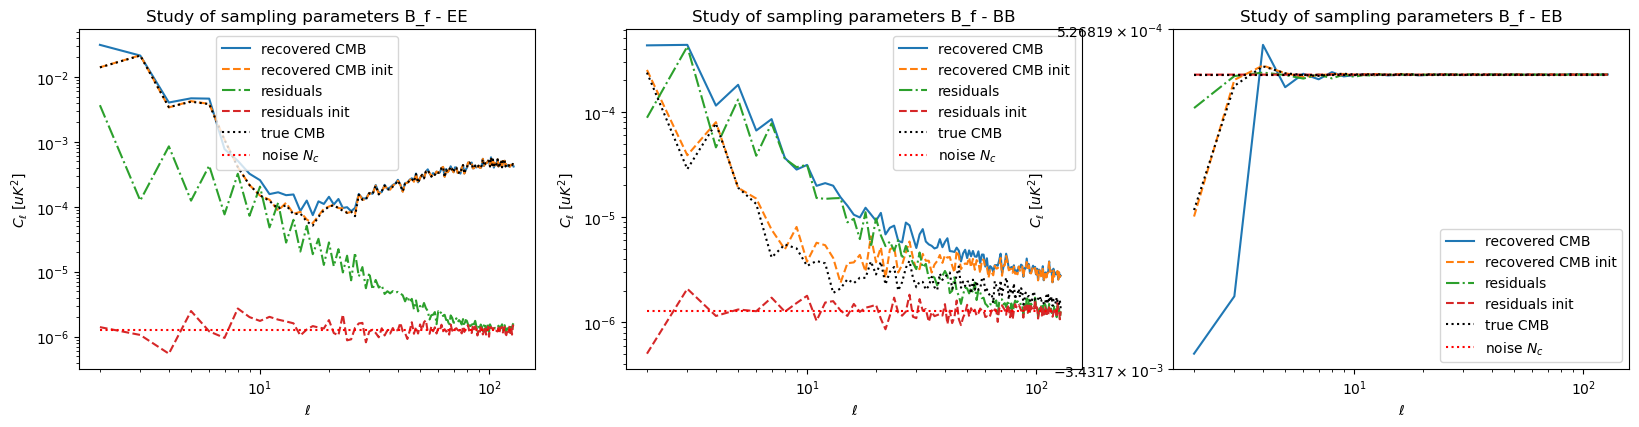

In [56]:
plt.figure(figsize=(20,15))
list_correl = ['EE', 'BB', 'EB']

number_subplots_convention = 331
for i in range(n_correl_to_plot):
    plt.subplot(number_subplots_convention+i)
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd[i,:], label='recovered CMB')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd_init[i,:], '--', label='recovered CMB init')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd[i,:], '-.', label='residuals')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd_init[i,:], '--', label='residuals init')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[i,:], 'k:', label='true CMB')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[i,:], 'r:', label='noise $N_c$')

    if i <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Study of sampling parameters B_f - {}'.format(list_correl[i]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
plt.show()

## Other results

In [57]:
# log_space_r = np.logspace(-8,3, num=100)

# if MICMAC_sampler_obj.r_true != 0:
#         log_r_true = np.log10(MICMAC_sampler_obj.r_true)
#         gap = .1
#         log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
# else:
#         log_space_r = np.logspace(-20,-2, num=100)
# c_ells_Wishart_modified = np.copy(c_ells_Wishart)
# for i in range(nstokes):
#         c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
# red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

# all_logproba_r = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_logspace, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [58]:
%%time
# all_logproba_samples = np.array([log_proba_func(B_f_sample, _input_freq_maps=input_freq_maps, red_cov_matrix=red_cov_matrix_sample, red_cov_approx_matrix=red_cov_approx_matrix) for B_f_sample in all_B_f_sample])
all_logproba_samples = np.array([log_proba_func(B_f_sample, full_data_without_CMB=full_data_without_CMB) for B_f_sample in all_B_f_sample])

CPU times: user 4min 55s, sys: 30.1 s, total: 5min 25s
Wall time: 49.1 s


In [ ]:
# log_proba_B_f_true = log_proba_func(init_params.ravel(order='F'), full_data_without_CMB=full_data_without_CMB, modified_sample_eta_maps=eta_maps, red_cov_approx_matrix=red_cov_approx_matrix)
log_proba_B_f_true = log_proba_func(init_params.ravel(order='F'), full_data_without_CMB=full_data_without_CMB)

In [59]:
# if MICMAC_sampler_obj.r_true != 0:
#         log_r_true = np.log10(MICMAC_sampler_obj.r_true)
#         gap = .7
#         log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
# else:
#         log_space_r = np.logspace(-20,-2, num=100)

# all_logproba_r_slow = np.array([MICMAC_sampler_obj.get_slow_conditional_proba_C_from_r(r_logspace, map_s_c=map_s_c, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [60]:
r_fit = all_B_f_sample.mean(axis=0)
print('B_f_fit :', r_fit)
# r_max = log_space_r[np.where(all_logproba_r==all_logproba_r.max())[0][0]]
# print('R_max :', r_max)

B_f_fit : [[ 0.34517876  0.00531938]
 [ 0.03225274  0.05026043]
 [ 0.0100446   0.13340783]
 [-0.00771299  0.476851  ]]


In [61]:
# r_fit_slow = all_B_f_sample_slow.mean()
# print('R_fit :', r_fit)
# r_max_slow = log_space_r[np.where(all_logproba_r_slow==all_logproba_r_slow.max())[0][0]]
# print('R_max :', r_max)

In [62]:
# plt.plot(log_space_r, all_logproba_r, label='Log-proba')
# plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r.min(), all_logproba_r.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
# plt.plot([r_fit, r_fit], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_fit = {:.5f}'.format(r_fit))
# plt.plot([r_max, r_max], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_max = {:.5f}'.format(r_max))
# # plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# # plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
# plt.xscale('log')
# plt.yscale('symlog')
# plt.xlabel('r values')
# plt.ylabel('Log-proba')
# plt.title('Griding Log proba')
# # plt.ylim(ymax=all_logproba_r.max())
# plt.legend()
# plt.show()

In [63]:
# plt.plot(log_space_r, all_logproba_r_slow, label='Log-proba')
# plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
# plt.plot([r_fit_slow, r_fit_slow], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], ':', label='r_fit = {:.5f}'.format(r_fit_slow))
# plt.plot([r_max_slow, r_max_slow], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], ':', label='r_max = {:.5f}'.format(r_max_slow))
# # plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# # plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
# plt.xscale('log')
# plt.yscale('symlog')
# plt.xlabel('r values')
# plt.ylabel('Log-proba')
# plt.title('Griding Log proba slow')
# # plt.ylim(ymax=all_logproba_r.max())
# plt.legend()
# plt.show()

In [64]:
all_B_f_sample.shape

(1001, 4, 2)

In [65]:
# red_c_ells_samples = np.zeros((number_steps_sampler, lmax+1-lmin, nstokes, nstokes))

# for i in range(number_steps_sampler):
#     red_c_ells_samples[i,...] = theoretical_red_cov_r0_total + all_B_f_sample[i]*theoretical_red_cov_r1_tensor

In [66]:
# plt.figure(figsize=(14,5))
# mean_r = np.round(all_B_f_sample.mean(), decimals=5)
# std_r = np.round(all_B_f_sample.std(), decimals=5)
# plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (68%)")

# plt.subplot(121)
# plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
# plt.plot(np.arange(number_steps_sampler+1), all_B_f_sample, '-.', label='samples')
# # plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
# plt.xlabel('Iterations')
# plt.ylabel('r samples')
# plt.title('')
# plt.loglog()
# plt.legend()

# plt.subplot(122)
# plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
# plt.plot(np.arange(number_steps_sampler+1), all_B_f_sample, '-.', label='samples')
# # plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
# plt.xlabel('Iterations')
# plt.ylabel('r samples')
# plt.loglog()
# plt.legend()
# plt.ylim(ymin=MICMAC_sampler_obj.r_true*.9, ymax=MICMAC_sampler_obj.r_true*1.1)
# plt.show()

# plt.show()

In [67]:
plt.plot([1,number_steps_sampler], [log_proba_B_f_true,log_proba_B_f_true], label='Log-proba B_f_true')
plt.plot(np.arange(number_steps_sampler+1), all_logproba_samples[:], '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')

plt.xlabel('Iterations')
plt.title('Log-proba r samples')
plt.loglog()
plt.legend()
plt.show()

NameError: name 'log_proba_B_f_true' is not defined

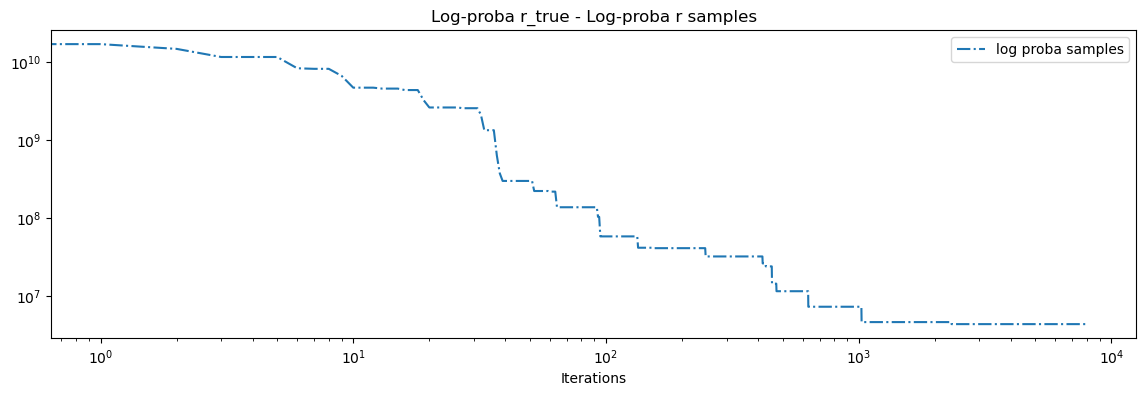

In [ ]:
plt.figure(figsize=(14,4))
# plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_B_f_true,log_proba_B_f_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), -(all_logproba_samples[:]-log_proba_B_f_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r_true - Log-proba r samples')
# plt.loglog()
plt.yscale('symlog')
plt.xscale('log')
plt.legend()
# plt.subplot(122)
# # plt.plot([1,number_steps_sampler], [log_proba_B_f_true,log_proba_B_f_true], label='Log-proba r_true')
# plt.plot(np.arange(number_steps_sampler+1), np.exp(all_logproba_samples[:]-log_proba_B_f_true), '-.', label='log proba samples')
# # plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
# plt.xlabel('Iterations')
# plt.title('e^(- (Log-proba r_true - Log-proba r samples))')
# plt.loglog()
# plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14,4))
# plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_B_f_true,log_proba_B_f_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler)+1, all_logproba_samples[1:]-all_logproba_samples[:-1], '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.yscale('symlog')
plt.xscale('log')
plt.legend()

# plt.subplot(122)
# plt.plot(np.arange(number_steps_sampler)+1, np.exp(all_logproba_samples[1:]-all_logproba_samples[:-1]), '-.', label='$\delta$log proba samples')
# # plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
# plt.xlabel('Iterations')
# plt.title('Diff Log-proba r samples')
# # plt.loglog()
# plt.xscale('log')
# plt.legend()
plt.show()